## Initial tests for sea ice diagnostics
François Massonnet & Nikolay Koldunov - 3rd May 2023 - DE_340 Coding Sprint from the BSC Terrace

First, we load the usual set of modules and libraries. The dask allows to parallelize Python operations

In [1]:
from aqua import Reader, catalogue, inspect_catalogue
from seaice_commondiags import *

import xarray as xr

# Dask: parallel computing with Python
from dask.distributed import Client
import dask
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})


Then we browse through the catalog of data. Not all available data has the sea ice variables and the requested weights  for interpolation. After playing around and looking at the repository of weights (`/work/bb1153/b382075/nextgems/weights/`) we found that the model `FESOM`, experiment `tco2559-ng5` and source `original_2d` can be regridded to `r025` (regular 1/4°)

In [15]:
cat = catalogue()
inspect_catalogue(cat)

IFS	tco3999-ng5	2.8km experiment, coupled with FESOM
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- interpolated_global	NN interpolation to 5400x2700 grid (lon=[-180,180], lat=[-90, 90])
IFS	tco2559-ng5	4km experiment, coupled with FESOM
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- interpolated_global	NN interpolation to 5400x2700 grid (lon=[-180,180], lat=[-90, 90])
	- lra-r100-mon	LRA monthly data 1x1 deg regular grid
IFS	tco1279-orca025	9km baseline, coupled to NEMO, deep conv ON
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- lra-r100-mon	LRA monthly data 1x1 deg regular grid
IFS	test-tco2559	4km experiment, coupled with FESOM
	- ICMGG_atm2d	2d output
	- ICMU_atm3d	3d output
IFS	test-tco79	TCO79 test data
	- short	original 2d output
	- long	coarse IFS data 1y

FESOM	tco3999-ng5	2.5km experiment,

['IFS', 'FESOM', 'ICON', 'MSWEP', 'ERA5', 'CERES', 'AVISO', 'PHC3', 'WOA18']

Questions open:
- To avoid confusion, wouldn't it be better to call those "datasets" since AVISO / CERES are not models and ERA5 is a reanalysis?

Now we instantiate a reader with the relevant information, asking to do the regridding. The specification of the variable is important here.

Questions open:

- The treatment of grid cell areas and land-sea mask is not yet systematic

In [5]:

reader = Reader(model   = "FESOM",
                exp     = "tco2559-ng5", 
                source  = "original_2d",
                regrid  = "r025",
                var     = "a_ice",
                )

Call the `retrieve` method to save everything into an `xarray` Dataset object  

In [18]:
data = reader.retrieve(fix = True)
data

<xarray.Dataset>
Dimensions:  (time: 8328, nod2: 7402886)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20T00:56:00 ... 2020-12-31T23:56:00
Dimensions without coordinates: nod2
Data variables:
    ci       (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
Attributes: (12/17)
    FESOM_model:                         FESOM2
    FESOM_website:                       fesom.de
    FESOM_git_SHA:                       469e74b1
    FESOM_MeshPath:                      /ec/res4/scratch/natr/RAPS/20/inputs...
    FESOM_mesh_representative_checksum:  
    FESOM_ClimateDataPath:               /ec/res4/scratch/natr/RAPS/20/inputs...
    ...                                  ...
    FESOM_use_floatice:                  0
    FESOM_whichEVP:                      1
    FESOM_evp_rheol_steps:               120
    FESOM_opt_visc:                      5
    FESOM_use_wsplit:                    -1
    history:                             2023-05-03 17:40:31 retrieved by AQU...

Load the mesh information manually. Question:
- Can this be included in the reader ?

In [7]:
mesh = xr.open_dataset('/work/bm1235/a270046/meshes/NG5_griddes_nodes_IFS.nc')

Create a dask client. Here things can be optimized, by finding the good tradeoff betwee number of workers and memory.

In [19]:
client = Client(n_workers = 20, 
                threads_per_worker = 1, 
                memory_limit = '4GB')
client

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41357 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/b382385/levante-spawner-preset//proxy/41357/status,
Dashboard: /user/b382385/levante-spawner-preset//proxy/41357/status,Workers: 20
Total threads: 20,Total memory: 186.26 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36067,Workers: 20
Dashboard: /user/b382385/levante-spawner-preset//proxy/41357/status,Total threads: 20
Started: Just now,Total memory: 186.26 GiB
Comm: tcp://127.0.0.1:44763,Total threads: 1
Dashboard: /user/b382385/levante-spawner-preset//proxy/41955/status,Memory: 9.31 GiB
Nanny: tcp://127.0.0.1:35149,


Load a specific variable: `ci`, which is sea ice area fraction in units. Then, regrid the data to a human-readable grid defined above (`r100`)

In [24]:
data.ci
mesh

<xarray.Dataset>
Dimensions:          (nod2: 7402886, grid_corners: 16, grid_rank: 1,
                      nlinks_max: 8, ntriags: 14741520, Three: 3, nlev: 69,
                      nlev_bnds: 70)
Dimensions without coordinates: nod2, grid_corners, grid_rank, nlinks_max,
                                ntriags, Three, nlev, nlev_bnds
Data variables: (12/13)
    grid_center_lon  (nod2) float64 ...
    grid_corner_lon  (nod2, grid_corners) float64 ...
    grid_center_lat  (nod2) float64 ...
    grid_corner_lat  (nod2, grid_corners) float64 ...
    grid_dims        (grid_rank) float64 ...
    grid_imask       (nod2) float64 ...
    ...               ...
    node_node_links  (nod2, nlinks_max) float64 ...
    triag_nodes      (ntriags, Three) float64 ...
    coast            (nod2) float64 ...
    depth            (nlev) float64 ...
    depth_bnds       (nlev_bnds) float64 ...
    depth_lev        (nod2) float64 ...
Attributes:
    Conventions:  CF-1.4
    history:      2022-03-19 08:26:17 GMT; Grid description file generated wi...

Load the grid cell areas. According to the definition of the reader function, grid_area returns the cell area of the destination grid if regridding has been performed

In [25]:
area = (mesh.cell_area * data.ci).sum(dim='nod2')


Question:
- how to do that based on a land-sea mask?

In [26]:
area

<xarray.DataArray (time: 8328)>
dask.array<sum-aggregate, shape=(8328,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20T00:56:00 ... 2020-12-31T23:56:00

Compute sea ice area (global)

In [27]:
area_comp = area.compute()

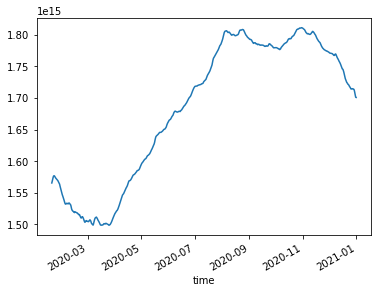

In [28]:
area_comp.plot()